In [40]:
import psycopg2 
import nltk
import csv
import pandas as pd
import numpy as np
import threading
import matplotlib.pyplot as plt
from collections import Counter
from dotenv import dotenv_values
from numpy import array, log, where
from nltk.stem import WordNetLemmatizer
from yake import KeywordExtractor
from nltk.corpus import stopwords
from wordcloud import WordCloud

config  = dotenv_values(".dbenv")

host = config["DB_HOST"]
db = config["DB_NAME"]
user = config["DB_USER"]
password = config["DB_PASSWORD"]
port = config["DB_PORT"]

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

def create_df(cursor_list):
    vendorids = [tuple[1] for tuple in cursor_list]
    ids = [tuple[0] for tuple in cursor_list]
    positionnames = [tuple[2] for tuple in cursor_list]
    companys = [tuple[3] for tuple in cursor_list]
    locations = [tuple[4] for tuple in cursor_list]
    searchterms = [tuple[5] for tuple in cursor_list]
    searchareas = [tuple[6] for tuple in cursor_list]
    scrapedats = [tuple[7] for tuple in cursor_list]
    createdats = [tuple[8] for tuple in cursor_list]
    postedats = [tuple[9] for tuple in cursor_list]
    salarys = [tuple[10] for tuple in cursor_list]
    benefits = [tuple[11] for tuple in cursor_list]
    requirements = [tuple[12] for tuple in cursor_list]
    descriptions = [tuple[13] for tuple in cursor_list]
    indeedlinks = [tuple[14] for tuple in cursor_list]

    df = pd.DataFrame(data = {'id': ids, 
                              'vendorid': vendorids, 
                              'positionname': positionnames, 
                              'company': companys, 
                              'location': locations, 
                              'searchterm': searchterms, 
                              'searcharea': searchareas, 
                              'scrapedat': scrapedats, 
                              'createdat': createdats, 
                              'postedat': postedats, 
                              'salary': salarys, 
                              'benefits': benefits, 
                              'requirements': requirements, 
                              'description': descriptions, 
                              'indeedlink': indeedlinks})

    return df

def remove_stopwords(tokens: list):
    filtered = [w for w in tokens if not w in stopwords.words('english')]
    return filtered

def lemmatize_tokens(tokens, lemmatizer):
    lemmatized_tokens = []
    for item in tokens:
        lemmatized_tokens.append(lemmatizer.lemmatize(item))
    return lemmatized_tokens

def convert_desc_str_to_token_list(descStr: str):
    tokens_list = descStr.split()
    filtered_tokens = remove_stopwords(tokens_list)
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = lemmatize_tokens(filtered_tokens, lemmatizer)
    new_description = ' '.join(lemmatized_tokens)
    return new_description

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\achek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\achek\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\achek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:
'''try: 
    conn = psycopg2.connect(dbname=db, user=user, password=password, host=host, port=port)
    cursor = conn.cursor() 
except:
    print("Failed to connect to database. Please try again.")'''

# cursor.execute('''SELECT x.* FROM public.jobs x
#                WHERE searchterm = 'Beauty'
#                limit 100''')
'''records = cursor.fetchall()'''
try:
    conn = psycopg2.connect(dbname=db, user=user, password=password, host=host, port=port)
    cursor = conn.cursor() 
except:
    print("Failed to connect to database. Please try again.")

cursor.execute('''SELECT x.* FROM public.jobs x
                WHERE id = 1001
                limit 100''')
records = cursor.fetchall()
print(records)

[(1001, '6a295727972fd45f', 'Dental Front Office', 'Nannette Benedict DDS & Associates', '5015 Scotts Valley Dr, Scotts Valley, CA 95066', 'Dentistry', 'San Jose, California', datetime.datetime(2023, 2, 4, 3, 15, 22, 747000), datetime.datetime(2023, 2, 4, 3, 16, 32, 355856), None, '$25 - $30 an hour', None, None, 'Full time dental administrator, 4 days weekly.We are a family practice in Scotts Valley with a long history and great prospects. We offer general dentistry, periodontics, and endodontics.Competitive salary, bonus system, health benefits, 401k, dental benefits, and nice folks!Job involves patient interaction, scheduling, phones.Must be able to explain insurance and prepare basic treatment plans.\nWe have a team of 6 administrators in our 14-operatory practice. We are losing one of our wonderful front office administrators to retirement! In a perfect world, we would hire in January, but have some flexibility. We are looking for the right fit above all.\nPlease submit resume wit

In [42]:
'''
# Zip it all up into one loooong string
descriptions = list(zip(*records))[13]
descStr = ' '.join(descriptions)

lemmatized_tokens = convert_desc_str_to_token_list(descStr)

keywords = kw_extractor.extract_keywords(lemmatized_tokens)
keywords = [x for x, y in keywords]
print(keywords) #insert into database'''
final_keywords = []
description = records[0][13]

lemmatized_tokens = convert_desc_str_to_token_list(description)

kw_extractor = KeywordExtractor(lan="en", n=1, top=10)

keywords = kw_extractor.extract_keywords(lemmatized_tokens)
keywords = [x for x, y in keywords]
final_keywords.append(keywords)
print(final_keywords[0]) #insert into database

['Scotts', 'Valley', 'year', 'dental', 'Preferred', 'benefits', 'insurance', 'day', 'prospects', 'administrator']


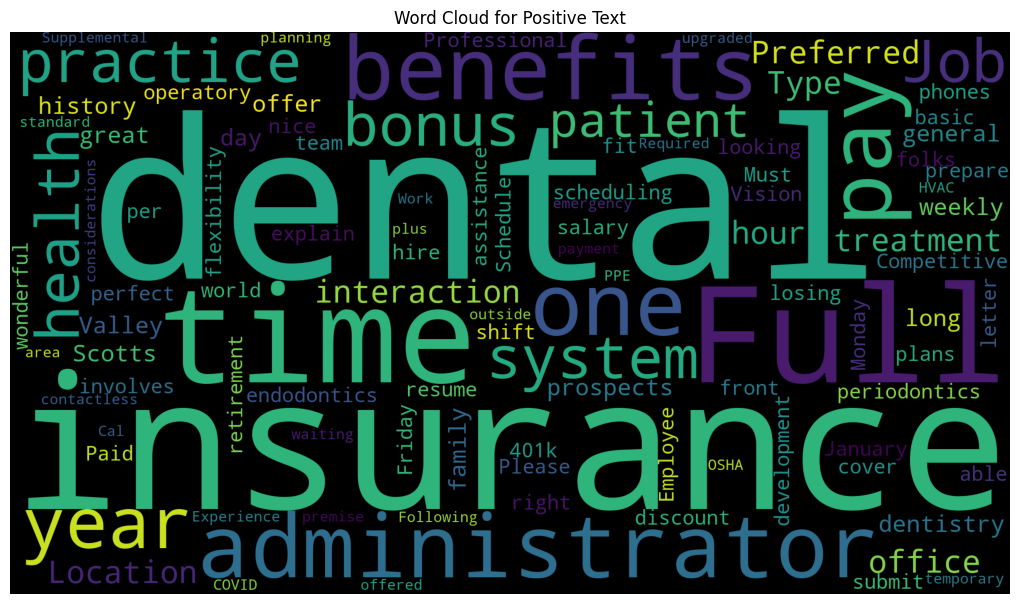

In [43]:
# WordCloud for Positive text
wordcloud = WordCloud(width=1920,height=1080).generate(lemmatized_tokens)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title("Word Cloud for Positive Text")
plt.show()

In [54]:
'''UPDATE jobs
SET keywords = CASE 
  WHEN id = start THEN [keyword1, keyword2, ...]
  WHEN id = start+1 THEN [keyword3, keyword4, ...]
.
.
.
END
WHERE id BETWEEN start AND end;'''

keyword_str = ','.join(final_keywords[0])

cursor.execute('''UPDATE public.jobs 
SET keywords = CASE 
  WHEN id = 1000 THEN NULL
END
WHERE id = 1000''')
conn.commit()

In [51]:
df = pd.read_csv('df_no_dupes_with_keywords.csv')
id_and_keyword_df = df[['id', 'unigram_keywords', 'bigram_keywords']]
unigrams_dict = dict(zip(id_and_keyword_df.id, id_and_keyword_df.unigram_keywords))


In [71]:
thread_size = len(unigrams_dict.keys())//10
ud_list = list(unigrams_dict.keys())

def kw_inject(start: int, end: int):
    while start <= end:
        id = start
        kw_str = unigrams_dict[ud_list[start]].replace('[','').replace(']','').replace('\'','')
        cursor.execute('''UPDATE public.jobs 
        SET keywords = CASE 
            WHEN id = {} THEN '{}'
        END
        WHERE id = {}'''.format(id, kw_str, id))
        conn.commit()
        start += 1
    return
'''
t1 = threading.Thread(target=kw_inject, args=(0, thread_size))
t2 = threading.Thread(target=kw_inject, args=(thread_size+1, 2*thread_size))
t3 = threading.Thread(target=kw_inject, args=(2*thread_size+1, 3*thread_size))
t4 = threading.Thread(target=kw_inject, args=(3*thread_size+1, 4*thread_size))
t5 = threading.Thread(target=kw_inject, args=(4*thread_size+1, 5*thread_size))
t6 = threading.Thread(target=kw_inject, args=(5*thread_size+1, 6*thread_size))
t7 = threading.Thread(target=kw_inject, args=(6*thread_size+1, 7*thread_size))
t8 = threading.Thread(target=kw_inject, args=(7*thread_size+1, 8*thread_size))
t9 = threading.Thread(target=kw_inject, args=(8*thread_size+1, 9*thread_size))
t10 = threading.Thread(target=kw_inject, args=(9*thread_size, len(unigrams_dict)-1))

t1.start()
t2.start()
t3.start()
t4.start()
t5.start()
t6.start()
t7.start()
t8.start()
t9.start()
t10.start()

t1.join()
t2.join()
t3.join()
t4.join()
t5.join()
t6.join()
t7.join()
t8.join()
t9.join()
t10.join()

print('done')'''

done
